In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
G = pd.read_csv('GOOGL.csv', parse_dates=['Date'],index_col=['Date'])
I = pd.read_csv('INTC.csv', parse_dates=['Date'],index_col=['Date'])

In [3]:
G_C = G[['Close']]
I_C = I[['Close']]

In [4]:
G_C.head()

,Close
Date,
2004-08-19,50.220219
2004-08-20,54.209209
2004-08-23,54.754753
2004-08-24,52.487488
2004-08-25,53.053055


In [5]:
I_C.head()

,Close
Date,
1980-03-17,0.325521
1980-03-18,0.322917
1980-03-19,0.330729
1980-03-20,0.329427
1980-03-21,0.317708


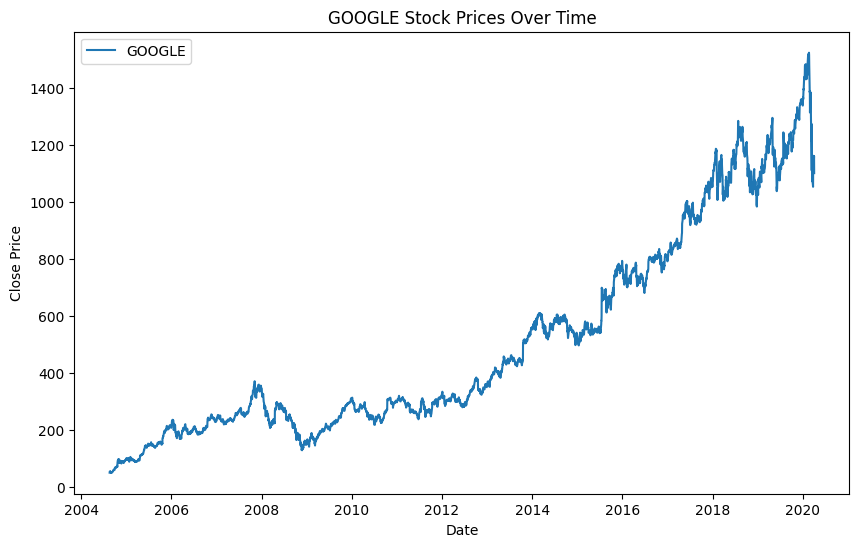

In [6]:
# Plot GOOGL
plt.figure(figsize=(10, 6))
plt.plot(G_C.index, G_C['Close'], label='GOOGLE')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('GOOGLE Stock Prices Over Time')
plt.legend()
plt.show()


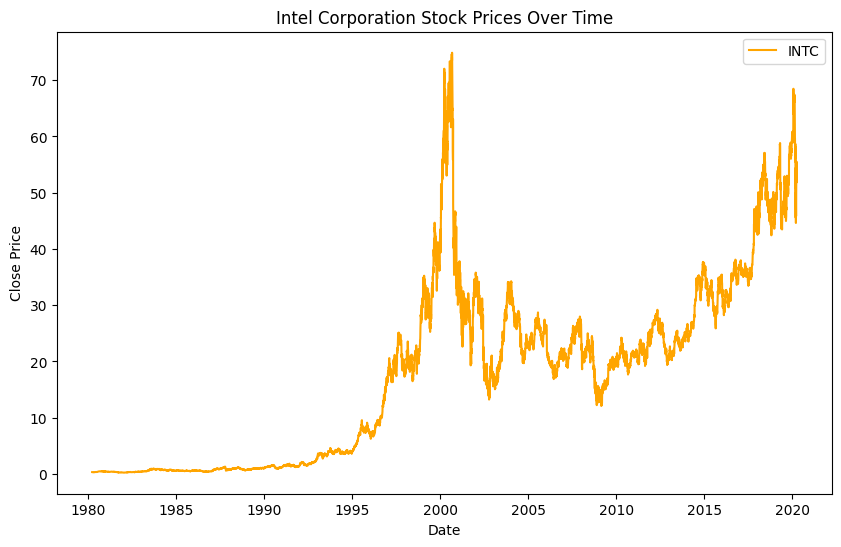

In [7]:
# Plot INTC
plt.figure(figsize=(10, 6))
plt.plot(I_C.index, I_C['Close'], label='INTC', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Intel Corporation Stock Prices Over Time')
plt.legend()
plt.show()


In [8]:
# Create windows
w_s = 5
h = 1

def windows(data, w_s, h):
    x, y = [], []
    for i in range(len(data) - w_s - h + 1):
        x.append(data[i:(i + w_s)])
        y.append(data[i + w_s + h - 1])
    return np.array(x), np.array(y)

In [9]:
x_G, y_G = windows(G_C['Close'].values, w_s, h)
x_I, y_I = windows(I_C['Close'].values, w_s, h)


In [10]:
def split_data(x, y):
    train_size = int(len(x) * 0.8)
    val_size = int(len(x) * 0.1)
    test_size = len(x) - train_size - val_size
    x_train = x[:train_size]
    y_train = y[:train_size]
    x_val = x[train_size:train_size + val_size]
    y_val = y[train_size:train_size + val_size]
    x_test = x[train_size + val_size:]
    y_test = y[train_size + val_size:]
    return x_train, y_train, x_val, y_val, x_test, y_test

In [11]:
x_train_G, y_train_G, x_val_G, y_val_G, x_test_G, y_test_G = split_data(x_G, y_G)
x_train_I, y_train_I, x_val_I, y_val_I, x_test_I, y_test_I = split_data(x_I, y_I)

In [12]:
x_train_G = np.reshape(x_train_G, (x_train_G.shape[0], x_train_G.shape[1]))
x_val_G = np.reshape(x_val_G, (x_val_G.shape[0], x_val_G.shape[1]))
x_test_G = np.reshape(x_test_G, (x_test_G.shape[0], x_test_G.shape[1]))

x_train_I = np.reshape(x_train_I, (x_train_I.shape[0], x_train_I.shape[1]))
x_val_I = np.reshape(x_val_I, (x_val_I.shape[0], x_val_I.shape[1]))
x_test_I = np.reshape(x_test_I, (x_test_I.shape[0], x_test_I.shape[1]))


In [13]:
print(f"GOOGL\n x_train: {x_train_G.shape}\n x_val: {x_val_G.shape}\n x_test: {x_test_G.shape}")
print(f"GOOGL\n y_train: {y_train_G.shape}\n y_val: {y_val_G.shape}\n y_test: {y_test_G.shape}")
print(f"INTC\n x_train: {x_train_I.shape}\n x_val: {x_val_I.shape}\n x_test: {x_test_I.shape}")
print(f"INTC\n y_train: {y_train_I.shape}\n y_val: {y_val_I.shape}\n y_test: {y_test_I.shape}")

GOOGL
 x_train: (3141, 5)
 x_val: (392, 5)
 x_test: (394, 5)
GOOGL
 y_train: (3141,)
 y_val: (392,)
 y_test: (394,)
INTC
 x_train: (8074, 5)
 x_val: (1009, 5)
 x_test: (1010, 5)
INTC
 y_train: (8074,)
 y_val: (1009,)
 y_test: (1010,)


LSTM (units=50) dan layer akhir berupa
node Perceptron dengan units=1. Activation function untuk LSTM menggunakan ReLU

In [14]:
def baseline_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=input_shape))
    model.add(Dense(units=1))
    model.compile(optimizer= 'Adam', loss='mean_squared_error')
    model.summary()
    return model

In [15]:
def modified_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=2860, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=1430, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='Adam', loss='mean_squared_error')
    model.summary()
    return model


In [16]:
early_stop_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

Baseline Model GOOGL

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50)                10400     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
99/99 [==============================] - 3s 19ms/step - loss: 25464.9902 - val_loss: 574.3862 - lr: 0.0010
Epoch 2/150
99/99 [==============================] - 1s 8ms/step - loss: 105.7717 - val_loss: 561.4905 - lr: 0.0010
Epoch 3/150
99/99 [==============================] - 1s 8ms/step - loss: 103.1565 - val_loss: 567.0188 - lr: 0.0010
Epoch 4/150
99/99 [==============================] - 1s 9ms/ste

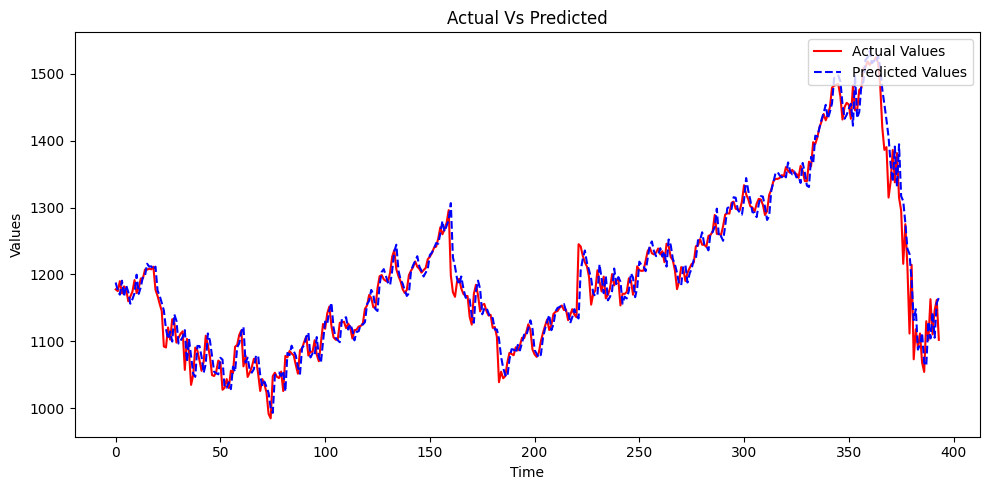

GOOGL - Test Loss: 580.0968017578125
GOOGL - Root Mean Squared Error (RMSE): 24.085198694746413
GOOGL - Mean Absolute Error (MAE): 16.627391834549492
GOOGL - Mean Absolute Percentage Error (MAPE): 10.75794474187216%


In [27]:
# Training model for G dataset
input_shape_G = (x_train_G.shape[1],1)
neural_model_G = baseline_model(input_shape_G)
training_history_G = neural_model_G.fit(x_train_G, y_train_G, epochs=150, batch_size=32,
                                        validation_data=(x_val_G, y_val_G),
                                        callbacks=[early_stop_callback, reduce_lr_callback])

# Evaluating model on G test data
evaluation_loss_G = neural_model_G.evaluate(x_test_G, y_test_G)
predictions_G = neural_model_G.predict(x_test_G)

# Plotting actual vs predicted values for G dataset
plt.figure(figsize=(10, 5))
plt.plot(y_test_G, 'r-', label='Actual Values')
plt.plot(predictions_G, 'b--', label='Predicted Values')
plt.title('Actual Vs Predicted')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Calculating performance metrics for G dataset
root_mse_G = np.sqrt(mean_squared_error(y_test_G, predictions_G))
mean_abs_error_G = mean_absolute_error(y_test_G, predictions_G)
mean_abs_percentage_error_G = np.mean(np.abs((y_test_G - predictions_G) / y_test_G)) * 100

print(f"GOOGL - Test Loss: {evaluation_loss_G}")
print(f"GOOGL - Root Mean Squared Error (RMSE): {root_mse_G}")
print(f"GOOGL - Mean Absolute Error (MAE): {mean_abs_error_G}")
print(f"GOOGL - Mean Absolute Percentage Error (MAPE): {mean_abs_percentage_error_G}%")

basic_metrics_G = (evaluation_loss_G, root_mse_G, mean_abs_error_G, mean_abs_percentage_error_G)

Modified Model GOOGL

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 2860)           32741280  
                                                                 
 dropout_4 (Dropout)         (None, 5, 2860)           0         
                                                                 
 lstm_7 (LSTM)               (None, 1430)              24544520  
                                                                 
 dropout_5 (Dropout)         (None, 1430)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 1431      
                                                                 
Total params: 57287231 (218.53 MB)
Trainable params: 57287231 (218.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15

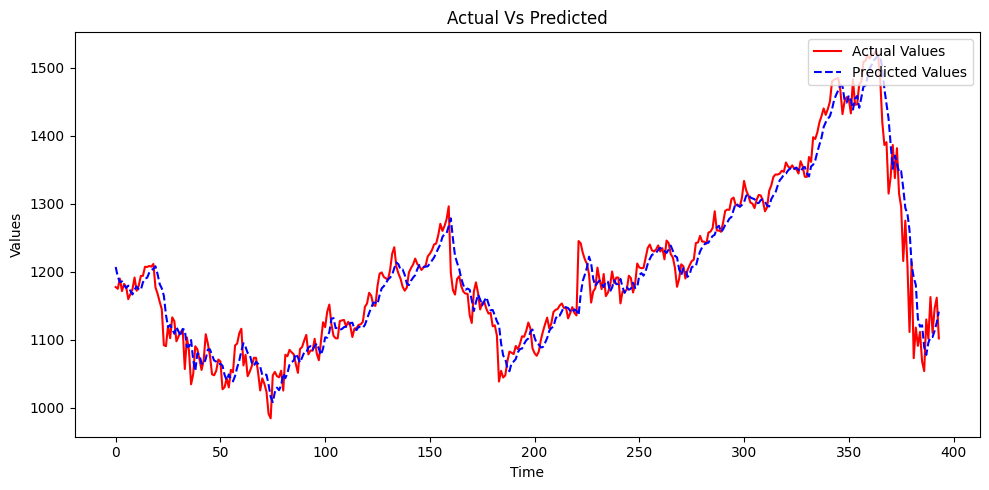

GOOGL - Test Loss: 758.9824829101562
GOOGL - Root Mean Squared Error (RMSE): 27.54963596137195
GOOGL - Mean Absolute Error (MAE): 19.89932452361596
GOOGL - Mean Absolute Percentage Error (MAPE): 10.584684434158808%


In [23]:
# Training model for G dataset
input_shape_G = (x_train_G.shape[1],1)
neural_model_G = modified_model(input_shape_G)
training_history_G = neural_model_G.fit(x_train_G, y_train_G, epochs=150, batch_size=32,
                                        validation_data=(x_val_G, y_val_G),
                                        callbacks=[early_stop_callback, reduce_lr_callback])

# Evaluating model on G test data
evaluation_loss_G = neural_model_G.evaluate(x_test_G, y_test_G)
predictions_G = neural_model_G.predict(x_test_G)

# Plotting actual vs predicted values for G dataset
plt.figure(figsize=(10, 5))
plt.plot(y_test_G, 'r-', label='Actual Values')
plt.plot(predictions_G, 'b--', label='Predicted Values')
plt.title('Actual Vs Predicted')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Calculating performance metrics for G dataset
root_mse_G = np.sqrt(mean_squared_error(y_test_G, predictions_G))
mean_abs_error_G = mean_absolute_error(y_test_G, predictions_G)
mean_abs_percentage_error_G = np.mean(np.abs((y_test_G - predictions_G) / y_test_G)) * 100

print(f"GOOGL - Test Loss: {evaluation_loss_G}")
print(f"GOOGL - Root Mean Squared Error (RMSE): {root_mse_G}")
print(f"GOOGL - Mean Absolute Error (MAE): {mean_abs_error_G}")
print(f"GOOGL - Mean Absolute Percentage Error (MAPE): {mean_abs_percentage_error_G}%")

modified_metrics_G = (evaluation_loss_G, root_mse_G, mean_abs_error_G, mean_abs_percentage_error_G)

Baseline Model INTC

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/180
162/162 [==============================] - 3s 9ms/step - loss: 7.1219 - val_loss: 0.4371 - lr: 0.0010
Epoch 2/180
162/162 [==============================] - 1s 8ms/step - loss: 0.7132 - val_loss: 0.4101 - lr: 0.0010
Epoch 3/180
162/162 [==============================] - 1s 8ms/step - loss: 0.6247 - val_loss: 0.4405 - lr: 0.0010
Epoch 4/180
162/162 [==============================] - 1s 9ms/step - los

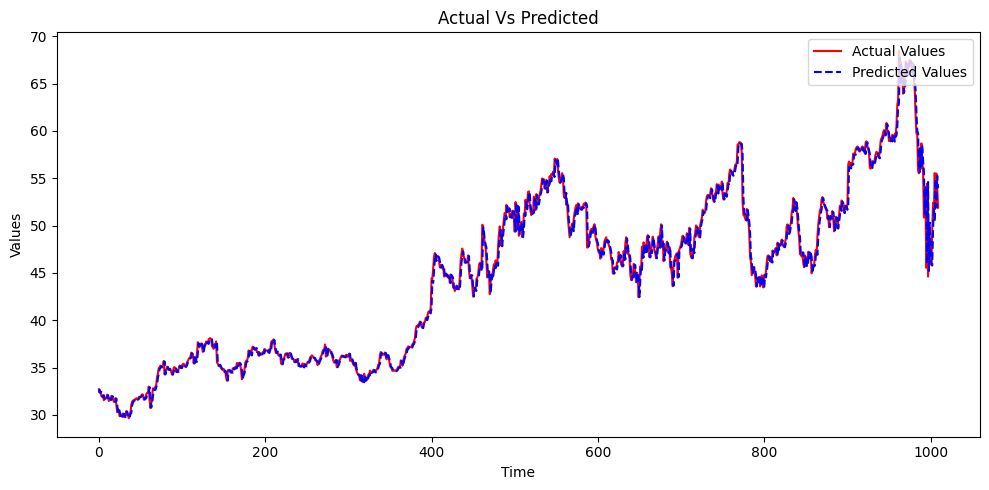

INTC - Test Loss: 1.0100427865982056
INTC - Root Mean Squared Error (RMSE): 1.00500885759678
INTC - Mean Absolute Error (MAE): 0.597469135322193
INTC - Mean Absolute Percentage Error (MAPE): 22.969242185487374%


In [19]:
# Training model for I dataset
input_shape_I = (x_train_I.shape[1],1)
neural_model_I = baseline_model(input_shape_I)
training_history_I = neural_model_I.fit(x_train_I, y_train_I, epochs=180, batch_size=50,
                                        validation_data=(x_val_I, y_val_I),
                                        callbacks=[early_stop_callback, reduce_lr_callback])

# Evaluating model on I test data
evaluation_loss_I = neural_model_I.evaluate(x_test_I, y_test_I)
predictions_I = neural_model_I.predict(x_test_I)

# Plotting actual vs predicted values for I dataset
plt.figure(figsize=(10, 5))
plt.plot(y_test_I, 'r-', label='Actual Values')
plt.plot(predictions_I, 'b--', label='Predicted Values')
plt.title('Actual Vs Predicted')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Calculating performance metrics for I dataset
root_mse_I = np.sqrt(mean_squared_error(y_test_I, predictions_I))
mean_abs_error_I = mean_absolute_error(y_test_I, predictions_I)
mean_abs_percentage_error_I = np.mean(np.abs((y_test_I - predictions_I) / y_test_I)) * 100

print(f"INTC - Test Loss: {evaluation_loss_I}")
print(f"INTC - Root Mean Squared Error (RMSE): {root_mse_I}")
print(f"INTC - Mean Absolute Error (MAE): {mean_abs_error_I}")
print(f"INTC - Mean Absolute Percentage Error (MAPE): {mean_abs_percentage_error_I}%")

basic_metrics_I = (evaluation_loss_I, root_mse_I, mean_abs_error_I, mean_abs_percentage_error_I)

Modified Model INTC

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 2860)           32741280  
                                                                 
 dropout_2 (Dropout)         (None, 5, 2860)           0         
                                                                 
 lstm_5 (LSTM)               (None, 1430)              24544520  
                                                                 
 dropout_3 (Dropout)         (None, 1430)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1431      
                                                                 
Total params: 57287231 (218.53 MB)
Trainable params: 57287231 (218.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/18

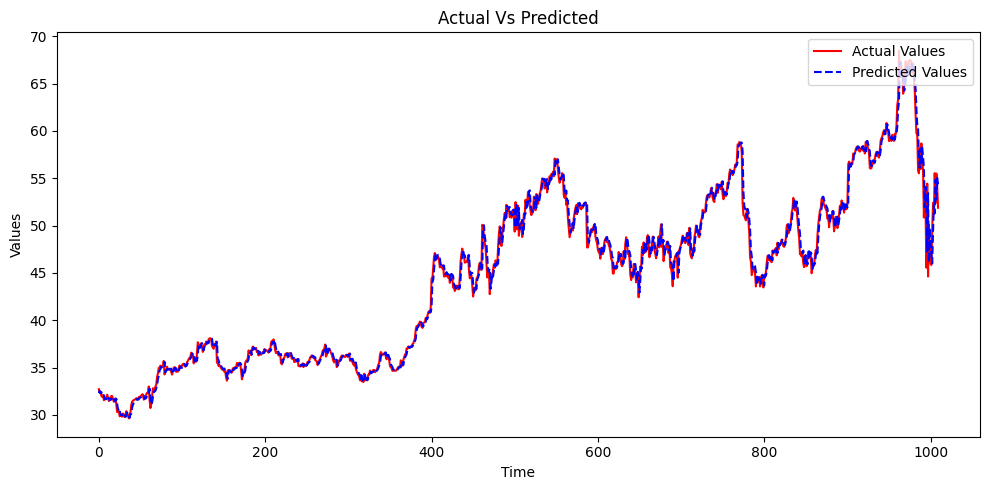

INTC - Test Loss: 0.966099202632904
INTC - Root Mean Squared Error (RMSE): 0.9829034334946142
INTC - Mean Absolute Error (MAE): 0.6010254699404877
INTC - Mean Absolute Percentage Error (MAPE): 23.08429921363753%


In [20]:
# Training model for I dataset
input_shape_I = (x_train_I.shape[1],1)
neural_model_I = modified_model(input_shape_I)
training_history_I = neural_model_I.fit(x_train_I, y_train_I, epochs=180, batch_size=50,
                                        validation_data=(x_val_I, y_val_I),
                                        callbacks=[early_stop_callback, reduce_lr_callback])

# Evaluating model on I test data
evaluation_loss_I = neural_model_I.evaluate(x_test_I, y_test_I)
predictions_I = neural_model_I.predict(x_test_I)

# Plotting actual vs predicted values for I dataset
plt.figure(figsize=(10, 5))
plt.plot(y_test_I, 'r-', label='Actual Values')
plt.plot(predictions_I, 'b--', label='Predicted Values')
plt.title('Actual Vs Predicted')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Calculating performance metrics for I dataset
root_mse_I = np.sqrt(mean_squared_error(y_test_I, predictions_I))
mean_abs_error_I = mean_absolute_error(y_test_I, predictions_I)
mean_abs_percentage_error_I = np.mean(np.abs((y_test_I - predictions_I) / y_test_I)) * 100

print(f"INTC - Test Loss: {evaluation_loss_I}")
print(f"INTC - Root Mean Squared Error (RMSE): {root_mse_I}")
print(f"INTC - Mean Absolute Error (MAE): {mean_abs_error_I}")
print(f"INTC - Mean Absolute Percentage Error (MAPE): {mean_abs_percentage_error_I}%")

modified_metrics_I = (evaluation_loss_I, root_mse_I, mean_abs_error_I, mean_abs_percentage_error_I)

In [24]:
# Ekstraksi metrik untuk GOOGL
basic_loss_G, basic_rmse_G, basic_mae_G, basic_mape_G = basic_metrics_G
modified_loss_G, modified_rmse_G, modified_mae_G, modified_mape_G = modified_metrics_G

# Ekstraksi metrik untuk INTC
basic_loss_I, basic_rmse_I, basic_mae_I, basic_mape_I = basic_metrics_I
modified_loss_I, modified_rmse_I, modified_mae_I, modified_mape_I = modified_metrics_I

In [25]:
def print_metrics(name, basic_metrics, modified_metrics):
    basic_loss, basic_rmse, basic_mae, basic_mape = basic_metrics
    modified_loss, modified_rmse, modified_mae, modified_mape = modified_metrics

    print(f"Metrics for {name}:")
    print(f"Basic Model - Loss: {basic_loss}\nRMSE: {basic_rmse}\nMAE: {basic_mae}\nMAPE: {basic_mape}%")
    print()
    print(f"Modified Model - Loss: {modified_loss}\nRMSE: {modified_rmse}\nMAE: {modified_mae}\nMAPE: {modified_mape}%")
    print()

In [26]:
print_metrics('GOOGL', basic_metrics_G, modified_metrics_G)
print_metrics('INTC', basic_metrics_I, modified_metrics_I)

Metrics for GOOGL:
Basic Model - Loss: 588.683837890625
RMSE: 24.26280780749217
MAE: 16.633525712841053
MAPE: 10.769983707667063%

Modified Model - Loss: 758.9824829101562
RMSE: 27.54963596137195
MAE: 19.89932452361596
MAPE: 10.584684434158808%

Metrics for INTC:
Basic Model - Loss: 1.0100427865982056
RMSE: 1.00500885759678
MAE: 0.597469135322193
MAPE: 22.969242185487374%

Modified Model - Loss: 0.966099202632904
RMSE: 0.9829034334946142
MAE: 0.6010254699404877
MAPE: 23.08429921363753%

